# Assignment 01: Comparison of loss function

### Basic Imports

In [1]:
import os
import time
import os.path as osp

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms
import torchvision

import matplotlib.pyplot as plt
from PIL import Image

### Hyperparameters

In [2]:
# random seed
SEED = 1 
NUM_CLASS = 10

# Training
BATCH_SIZE = 128
NUM_EPOCHS = 30
EVAL_INTERVAL=1
SAVE_DIR = './log'

# Optimizer
LEARNING_RATE = 1e-1
MOMENTUM = 0.9
STEP=5
GAMMA=0.5

### Device

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


### Dataset


In [4]:
# cifar10 transform
transform_cifar10_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_cifar10_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_set = torchvision.datasets.CIFAR10(root='../data', train=True,
                                        download=True, transform=transform_cifar10_train)
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='../data', train=False,
                                       download=True, transform=transform_cifar10_test)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Files already downloaded and verified
Files already downloaded and verified


### Model Define

In [5]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 4, 3)  
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(4, 8, 3)  
        self.fc1 = nn.Linear(8 * 6 * 6, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 8 * 6 * 6)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [6]:
## for loss_type, use 0 for L1Loss; use 1 for CrossEntropyLoss; use 2 for FocalLoss.
## gamma for FocalLoss.
loss_types = ['L1Loss','CrossEntropyLoss','FocalLoss_0.5','FocalLoss_2']
evaluation = ['training_loss', 'training_acc', 'testing_loss', 'testing_acc']
gamma = [0, 0.5, 2]

In [7]:
def one_hot_target(target):
    num_samples = target.shape[0]
    
    expanded_target = torch.zeros((num_samples, 10))
    expanded_target = expanded_target.to(device)
    
    expanded_target.scatter_(1, target.view(-1, 1), 1)
    
    return expanded_target

In [8]:
def train_batch(model, image, target, gamma):
    """
    Perform one training batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to train.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated by the defined loss function loss_fn().
    """
    ##################### Write your answer here ##################
    output = model(image)
    
    if loss_type == 'L1Loss':
        criterion = nn.L1Loss()
        output = F.softmax(output, dim=1)
        target = one_hot_target(target)
        target = target.to(device)
        loss = criterion(output, target)
    elif loss_type == 'CrossEntropyLoss':
        criterion = nn.CrossEntropyLoss()
        loss = criterion(output, target)
    elif loss_type == 'FocalLoss_0.5' or loss_type == 'FocalLoss_2':
        criterion = nn.CrossEntropyLoss()
        loss = criterion(output, target)
        p_t = torch.exp(-loss)
        loss = -(1 - p_t)**gamma * torch.log(p_t)
    ###############################################################

    return output, loss

In [9]:
def test_batch(model, image, target, gamma):
    """
    Perform one testing batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to evaluate.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated for the batch.
    """

    ##################### Write your answer here ##################
    output = model(image)
    
    if loss_type == 'L1Loss':
        criterion = nn.L1Loss()
        output = F.softmax(output, dim=1)
        target = one_hot_target(target)
        target = target.to(device)
        loss = criterion(output, target)
    elif loss_type == 'CrossEntropyLoss':
        criterion = nn.CrossEntropyLoss()
        loss = criterion(output, target)
    elif loss_type == 'FocalLoss_0.5' or loss_type == 'FocalLoss_2':
        criterion = nn.CrossEntropyLoss()
        loss = criterion(output, target)
        p_t = torch.exp(-loss)
        loss = -(1 - p_t)**gamma * torch.log(p_t)
    ###############################################################

    return output, loss

### Model Training

Four performance metrics are defined to evaluate each loss function: Training loss, Training accuracy, Testing loss, Testing accuracy. We check every pack of the evaluation from each epoch.

In [10]:
training_loss = {}
training_acc = {}
testing_loss = {}
testing_acc = {}

for loss_type in loss_types:
    model = ConvNet()
    model.to(device)
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)
    
    if loss_type == 'FocalLoss_0.5':
        gamma_type = gamma[1]
    elif loss_type == 'FocalLoss_2':
        gamma_type = gamma[2]
    else:
        gamma_type = gamma[0]
    
    training_loss[loss_type] = []
    training_acc[loss_type] = []
    testing_loss[loss_type] = []
    testing_acc[loss_type] = []
    
    for epoch in range(NUM_EPOCHS):
        model.train()
        torch.cuda.empty_cache()

        ##########################
        ### Training
        ##########################

        running_cls_loss = 0.0
        running_cls_corrects = 0

        for batch_idx, (image, target) in enumerate(train_dataloader):
        
            image = image.to(device)
            target = target.to(device)
        
            # train model
            outputs, loss = train_batch(model, image, target, gamma_type)
        
            _, preds = torch.max(outputs, 1)

            loss_data = loss.data.item()
            if np.isnan(loss_data):
                raise ValueError('loss is nan while training')
            running_cls_loss += loss.item()
            running_cls_corrects += torch.sum(preds == target.data)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        epoch_loss = running_cls_loss / len(train_dataloader)
        epoch_acc = running_cls_corrects.double() / len(train_set)

        print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        training_loss[loss_type].append(epoch_loss)
        training_acc[loss_type].append(epoch_acc.cpu().detach().numpy())

        # change learning rate
        scheduler.step()

        ##########################
        ### Testing
        ##########################
        # # eval model during training or in the last epoch
        if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
            print('Begin test......')
            model.eval()
    
            val_loss = 0.0
            val_corrects = 0

            for batch_idx, (image, target) in enumerate(test_dataloader):

                image = image.to(device)
                target = target.to(device)

                # test model
                outputs, loss = test_batch(model, image, target, gamma_type)
                _, preds = torch.max(outputs, 1)
            
                val_loss += loss.item()
                val_corrects += torch.sum(preds == target.data)

            val_loss = val_loss / len(test_dataloader)
            val_acc = val_corrects.double() / len(test_set)
            print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
            testing_loss[loss_type].append(val_loss)
            testing_acc[loss_type].append(val_acc.cpu().detach().numpy())

            # save the model in last epoch
            if (epoch + 1) == NUM_EPOCHS:
            
                state = {
                'state_dict': model.state_dict(),
                'acc': epoch_acc,
                'epoch': (epoch+1),
                }

                # check the dir
                if not os.path.exists(SAVE_DIR):
                    os.makedirs(SAVE_DIR)

                # save the state
                torch.save(state, osp.join(SAVE_DIR, f"{loss_type}_checkpoint_{gamma_type}_{epoch+1}.pth"))

Epoch: 1/30 Train Loss: 0.1733 Acc: 0.1327
Begin test......
Test Loss: 0.1625 Acc: 0.1858
Epoch: 2/30 Train Loss: 0.1617 Acc: 0.1946
Begin test......
Test Loss: 0.1538 Acc: 0.2350
Epoch: 3/30 Train Loss: 0.1560 Acc: 0.2219
Begin test......
Test Loss: 0.1515 Acc: 0.2419
Epoch: 4/30 Train Loss: 0.1503 Acc: 0.2505
Begin test......
Test Loss: 0.1434 Acc: 0.2845
Epoch: 5/30 Train Loss: 0.1474 Acc: 0.2650
Begin test......
Test Loss: 0.1392 Acc: 0.3036
Epoch: 6/30 Train Loss: 0.1443 Acc: 0.2806
Begin test......
Test Loss: 0.1381 Acc: 0.3108
Epoch: 7/30 Train Loss: 0.1430 Acc: 0.2877
Begin test......
Test Loss: 0.1389 Acc: 0.3047
Epoch: 8/30 Train Loss: 0.1420 Acc: 0.2922
Begin test......
Test Loss: 0.1355 Acc: 0.3227
Epoch: 9/30 Train Loss: 0.1405 Acc: 0.3001
Begin test......
Test Loss: 0.1359 Acc: 0.3193
Epoch: 10/30 Train Loss: 0.1394 Acc: 0.3045
Begin test......
Test Loss: 0.1353 Acc: 0.3234
Epoch: 11/30 Train Loss: 0.1372 Acc: 0.3158
Begin test......
Test Loss: 0.1340 Acc: 0.3303
Epoch: 1

In [51]:
def plot_models_info(model_data, title):
    epochs = range(1, len(model_data[0][0]) + 1)
    plt.figure(figsize=(15, 12))
    plt.suptitle(title, fontsize=16)

    for i in range(4):
        plt.subplot(2, 2, i + 1)
        plt.plot(epochs, model_data[i][0], 'r', label='L1Loss')
        plt.plot(epochs, model_data[i][1], 'g', label='CrossEntropyLoss')
        plt.plot(epochs, model_data[i][2], 'b', label='FocalLoss_0.5')
        plt.plot(epochs, model_data[i][3], 'y', label='FocalLoss_2')
        plt.title('Model ' + evaluation[i])
        plt.xlabel('Epochs')
        plt.ylabel(evaluation[i])
        plt.legend()

    plt.tight_layout()
    fig=plt.gcf()
    fig.savefig('./pic/' + title + '.png')
    plt.show()

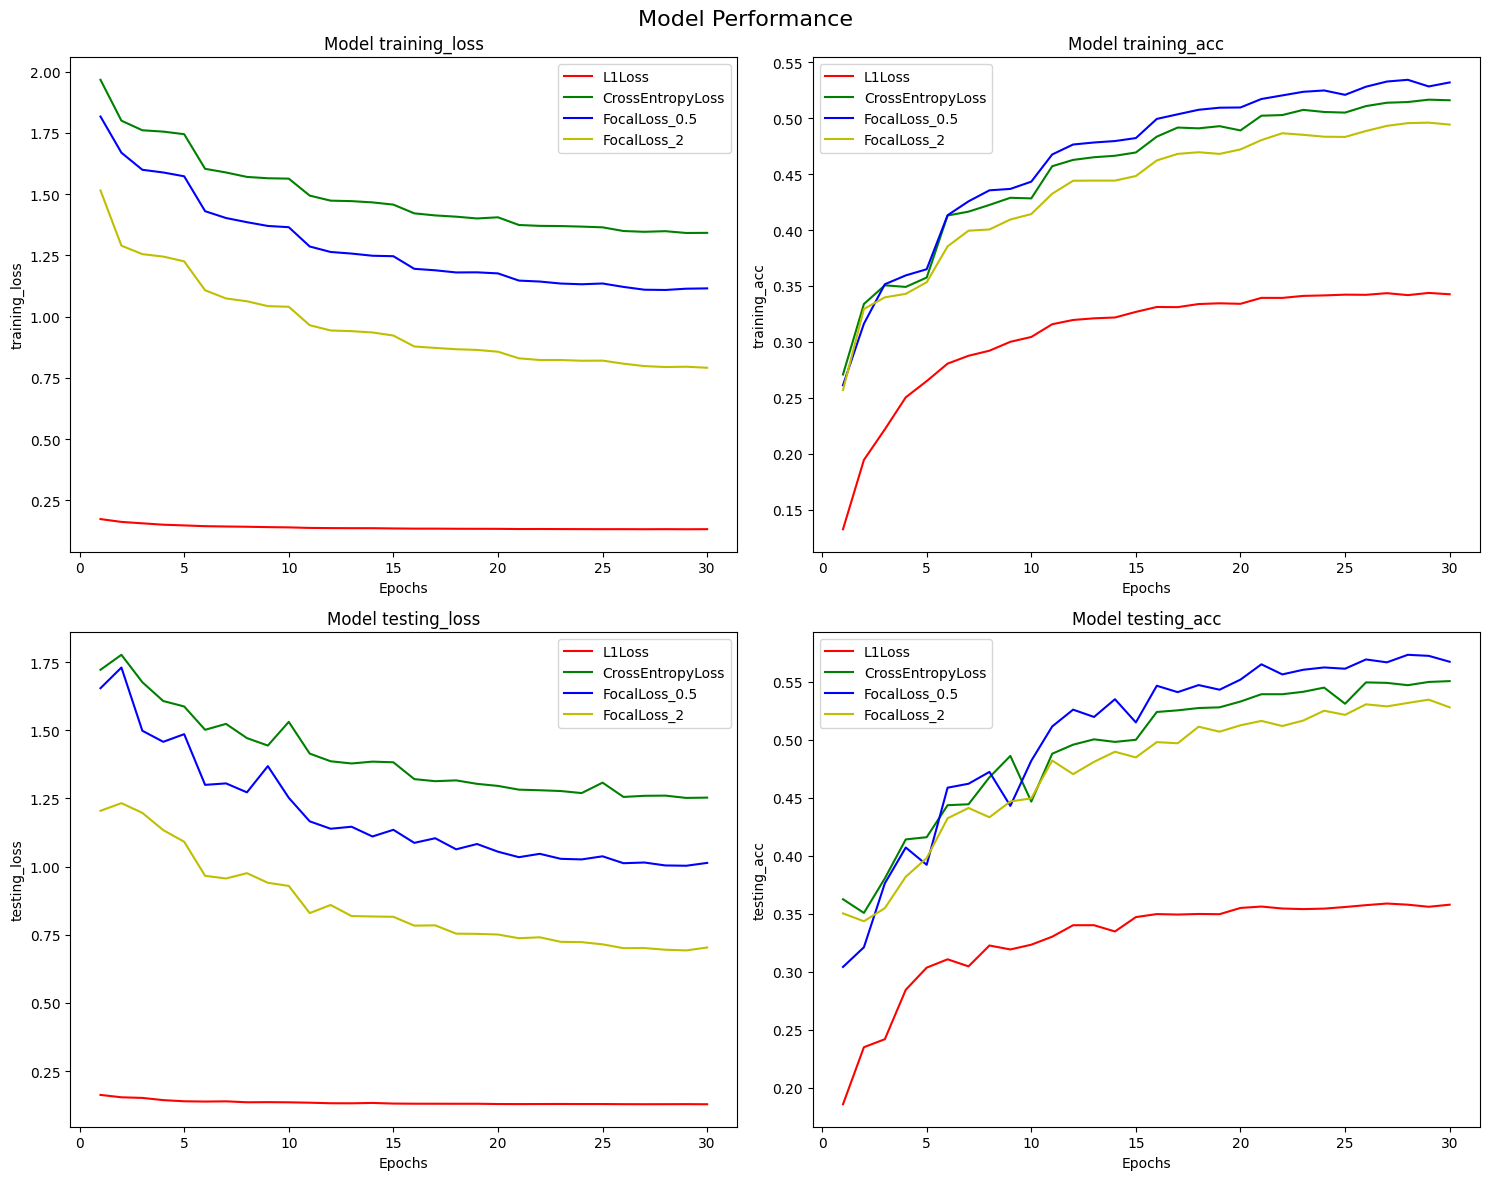

In [52]:
model_data = [
    (training_loss['L1Loss'], training_loss['CrossEntropyLoss'], training_loss['FocalLoss_0.5'], training_loss['FocalLoss_2']),
    (training_acc['L1Loss'], training_acc['CrossEntropyLoss'], training_acc['FocalLoss_0.5'], training_acc['FocalLoss_2']),
    (testing_loss['L1Loss'], testing_loss['CrossEntropyLoss'], testing_loss['FocalLoss_0.5'], testing_loss['FocalLoss_2']),
    (testing_acc['L1Loss'], testing_acc['CrossEntropyLoss'], testing_acc['FocalLoss_0.5'], testing_acc['FocalLoss_2'])
]

plot_models_info(model_data, 'Model Performance')

In [46]:
def plot_model_info(model_data, title):
    epochs = range(1, len(model_data[0][0]) + 1)
    plt.figure(figsize=(12, 5))
    plt.suptitle(title, fontsize=16)

    for i in range(2):
        plt.subplot(1, 2, i + 1)
        plt.plot(epochs, model_data[i][0], 'r', label='Training')
        plt.plot(epochs, model_data[i][1], 'g', label='Testing')
        plt.title('Model')
        plt.xlabel('Epochs')
        if i == 0:
            plt.ylabel('loss')
        elif i == 1:
            plt.ylabel('accuracy')
        plt.legend()

    plt.tight_layout()
    fig=plt.gcf()
    fig.savefig('./pic/' + title + '.png')
    plt.show()

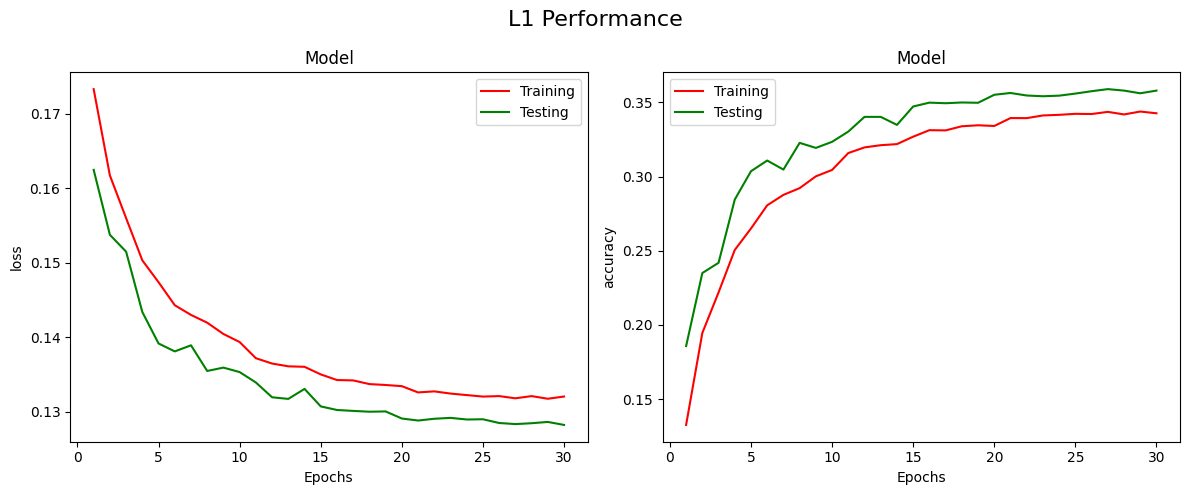

In [47]:
L1_data = [
    (training_loss['L1Loss'], testing_loss['L1Loss']),
    (training_acc['L1Loss'], testing_acc['L1Loss'])
]

plot_model_info(L1_data, 'L1 Performance')

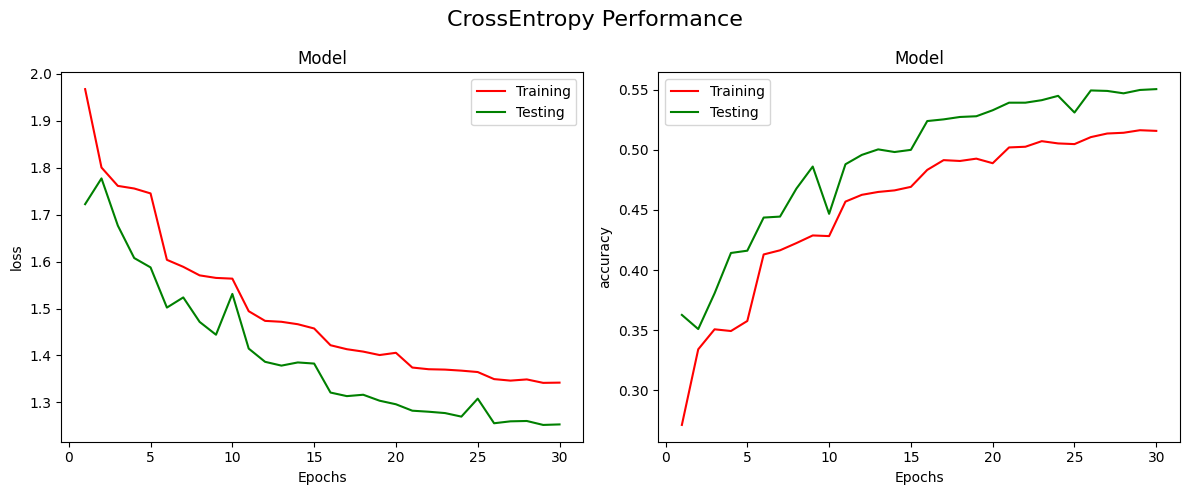

In [48]:
CrossEntropy_data = [
    (training_loss['CrossEntropyLoss'], testing_loss['CrossEntropyLoss']),
    (training_acc['CrossEntropyLoss'], testing_acc['CrossEntropyLoss'])
]

plot_model_info(CrossEntropy_data, 'CrossEntropy Performance')

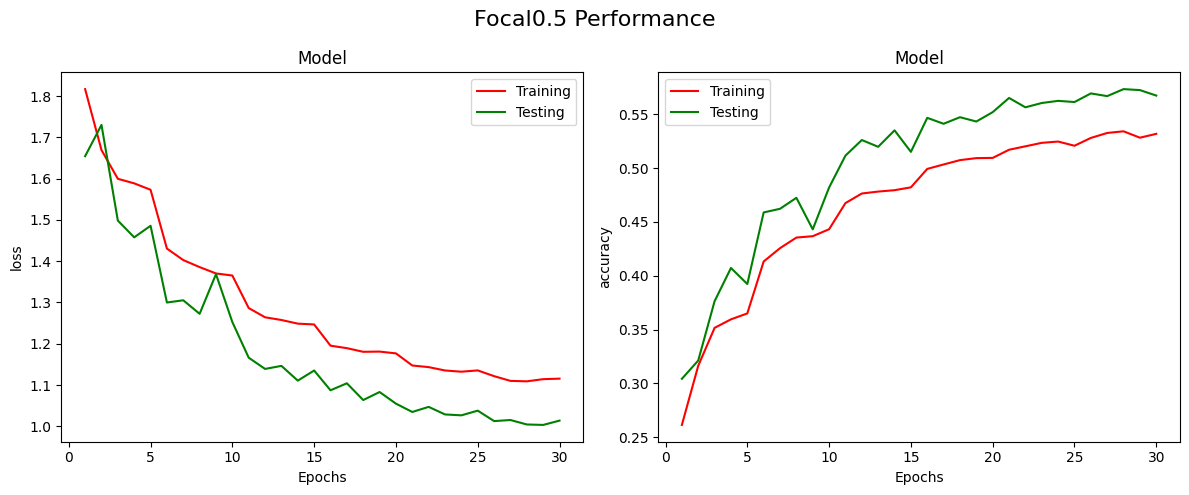

In [49]:
Focal_half = [
    (training_loss['FocalLoss_0.5'], testing_loss['FocalLoss_0.5']),
    (training_acc['FocalLoss_0.5'], testing_acc['FocalLoss_0.5'])
]

plot_model_info(Focal_half, 'Focal0.5 Performance')

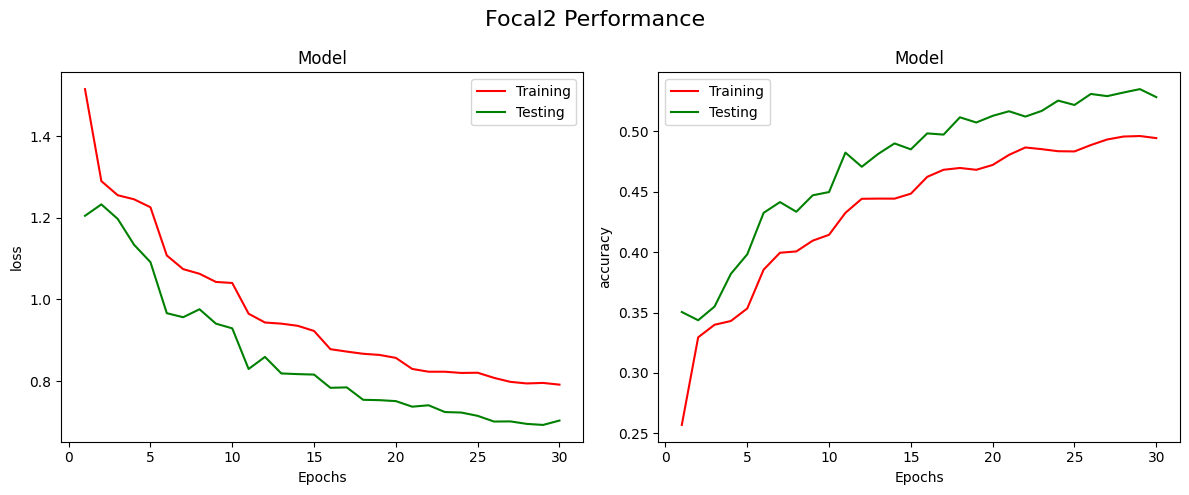

In [50]:
Focal_two = [
    (training_loss['FocalLoss_2'], testing_loss['FocalLoss_2']),
    (training_acc['FocalLoss_2'], testing_acc['FocalLoss_2'])
]

plot_model_info(Focal_two, 'Focal2 Performance')